# MODEL TRAINING - PIPELINE

In [236]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [293]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, PowerTransformer, OneHotEncoder, FunctionTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
import scipy.stats as stats

In [238]:
# get main, clean prepared df 
from model_pipeline import data_preparation
df = data_preparation()

In [239]:
# ----------------------------------
# HELPER - MEAN TARGET VARIABLE
#-----------------------------------
def target_mean():
    target = df["child_mortality_igme"]
    target_mean = target.mean()
    print(f"Actual Mean Target: {round(target_mean, 2)}")
    return target_mean

In [241]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [305]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals, size=residuals)
    
    plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    ax.set_xlim(-15, y_true.max())
    ax.set_ylim(-15, y_true.max())
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [244]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(5)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(5)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)}''')   
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(5)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(5)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(5)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(5)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error", "rmsle": "neg_root_mean_squared_log_error"}

### PIPELINE

In [247]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "Entity", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = X["world_regions_wb"].unique()
incomegroups_list = X["world_income_group"].unique()

skewed_variables = num_variables.copy() #rightskewed vars
for el in rest:
    if el in skewed_variables:
        skewed_variables.remove(el)
        
others = ["years_of_schooling", "share_of_population_urban", "vaccination_coverage_who_unicef"] #leftskewed or normal-skewed vars

In [248]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

In [249]:
# Combis
def comb_feature(X):
    X = X.copy()
    X["bip_water"] = X["nurses_and_midwives_per_1000_people"] * X["physicians_per_1000_people"]
    return X[["bip_water"]]

comb_features = FunctionTransformer(comb_feature)

In [250]:
# -------------------------------------
# KMeans Cluster outside of Pipeline
#--------------------------------------

X_train_cluster = X_train[num_variables].copy()

kmeans_rscaler = RobustScaler()
X_kmeans_scaled = kmeans_rscaler.fit_transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=6, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
kmeans_cluster_columns = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_train.copy().index)
X_cl_train = pd.concat([X_train.copy(), kmeans_cluster_columns], axis=1) #create new X from X_train & append kmeans cols

In [251]:
# ------------------------------------------
# Preprocessing, Training & CROSS VALIDATION
#------------------------------------------

# handle numeric variables
num_pipeline = Pipeline([
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ("transformer", PowerTransformer()),
    ("scaler", RobustScaler()),

    #("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    #("log", FunctionTransformer(np.log1p)),
    #("scaler", RobustScaler())
])

right_skew_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ('log', FunctionTransformer(np.log1p)),
    ('scale', RobustScaler()) 
])

rest_transformer = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    ('log', PowerTransformer()),
    ('scale', RobustScaler()) 
])

# handle categoric variable
cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder(
        drop = "first",
        handle_unknown = "ignore",
        categories=[regions_list, incomegroups_list],
        sparse_output=False
    ))
])
               
preprocessor = ColumnTransformer(transformers=[
    ("numeric_1", right_skew_transformer, skewed_variables),
    ("numeric_2", rest_transformer, others),
    ("categoric", cat_pipeline, cat_variables),
    #('combined', Pipeline([
    #    ('interact', comb_features),
    #    ("imputer", KNNImputer(n_neighbors=5, weights="distance", add_indicator=False)),
    #    ('log', FunctionTransformer(np.log1p)),
    #    ('scale', RobustScaler()) 
    # ]), ['nurses_and_midwives_per_1000_people', 'physicians_per_1000_people'])
    
    #("comb_features", comb_features, ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people"]),
    
    #("drop_cols", "drop", year_col)
    
], remainder="passthrough")

gk = GroupKFold(n_splits=5)

### BASELINE MODEL (LINEAR REGRESSION)

In [284]:
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])
#Target is rightskewed, logtransform y before training
lr_pipeline_y_log  = TransformedTargetRegressor(
    regressor=lr_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

lr_r2_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE Score: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE Score: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.63963659 0.84753118 0.78621665 0.7021841  0.73267734]
Mean R2 Score: 0.74

MAE:

Folds MAE scores: [ 7.81974604  9.15171418 10.8827563  12.36959597  9.06721478]
Mean MAE Score: 9.86
Std MAE Score: 1.59

RMSE:

Folds RMSE scores: [10.47628893 15.6637813  16.03831993 25.84073175 13.71946583]
Mean RMSE Score: 16.35
Std RMSE Score: 5.14

-----------------------------------------



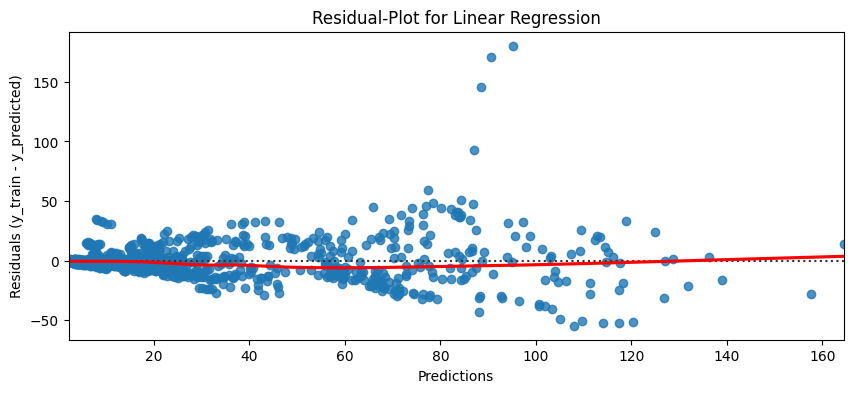

In [256]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_cl_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

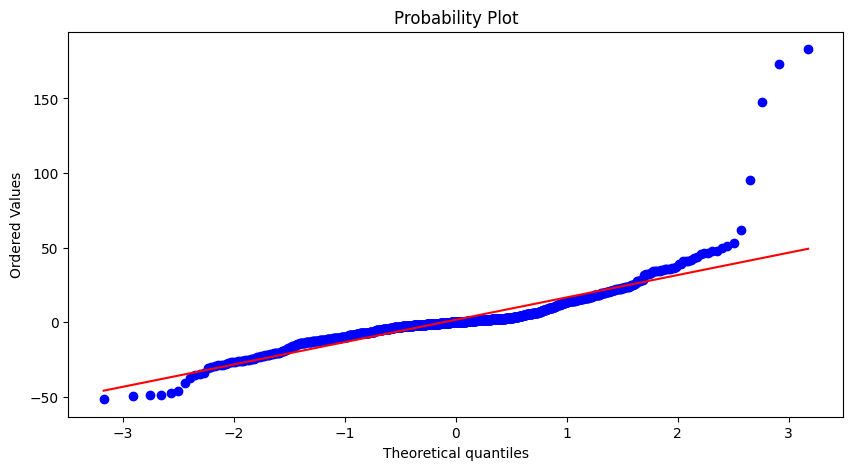

In [306]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR BASE MODEL
#--------------------------------------------------
prob_plot(lr_residuals)

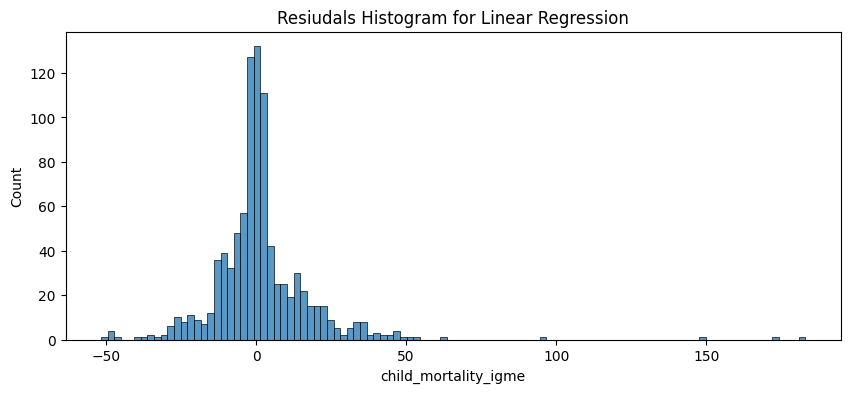

In [279]:
# -------------------------------------------------
# HISTOGRAM PLOT OF RESIDUALS FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
residuals_hist(lr_residuals, "Linear Regression")

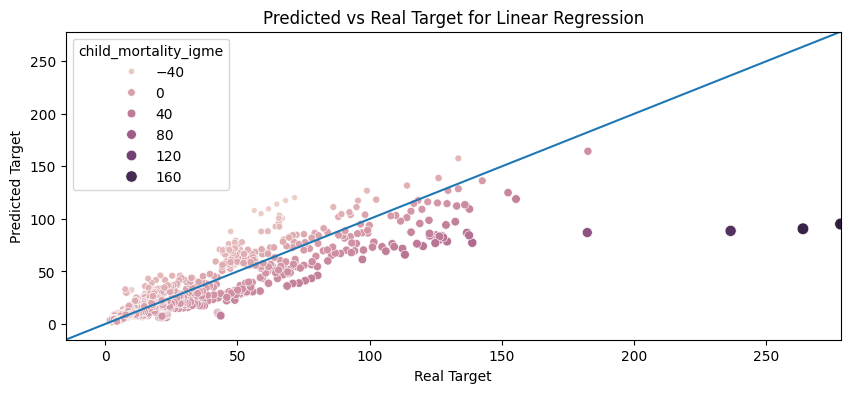

In [280]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")

In [282]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", Ridge())
])
#Target is rightskewed, logtransform y before training
ridge_pipeline_y_log  = TransformedTargetRegressor(
    regressor=ridge_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

ridge_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10, 100]
}

ridge_grid = GridSearchCV(ridge_pipeline_y_log, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_cl_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_

show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [0.8, 0.78, 0.8, 0.82, 0.81]
            
Mean Train R2 Score: 0.8
            
Test Folds R2 Scores: [0.65, 0.83, 0.8, 0.72, 0.75]
            
Mean Test R2 Score (best_score_): 0.75

MAE:

Train Folds MAE Scores: [9.15, 8.38, 8.12, 8.19, 8.43]
            
Mean Train MAE Score: 8.45
            
Test Folds MAE Scores: [7.69, 9.78, 10.54, 10.96, 8.84]
            
Mean Test MAE Score: 9.56
            
Std Test MAE Score: 1.18

RMSE:

Train Folds RMSE Scores: [17.18, 16.08, 16.0, 13.12, 16.51]
            
Mean Train RMSE Score: 15.78
            
Test Folds RMSE Scores: [10.28, 16.72, 15.45, 25.14, 13.34]
            
Mean Test RMSE Score: 16.19
            
Std Test MAE Score: 4.98
-----------------------------------------



,regressor,Pipeline(step...e(alpha=10))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


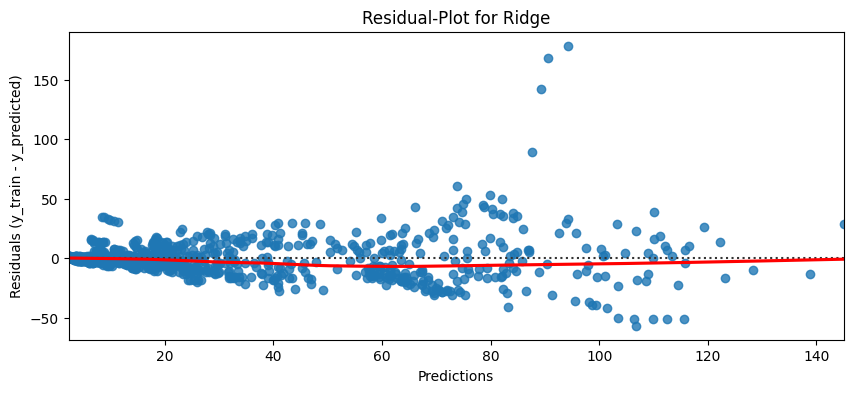

In [285]:
# -------------------------------------------------
# RESIDUAL PLOT FOR RIDGE
#--------------------------------------------------
ridge_y_predicts = cross_val_predict(best_ridge_model, X_cl_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

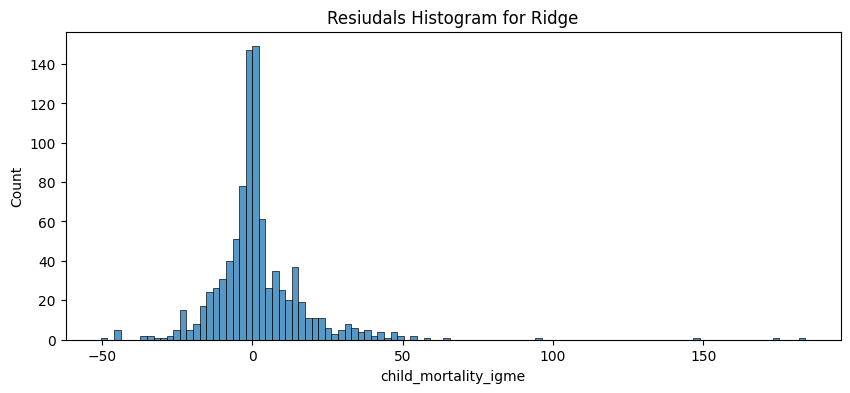

In [286]:
# -------------------------------------------------
# HISTOGRAM PLOT OF RESIDUALS FOR RIDGE MODEL
#--------------------------------------------------
residuals_hist(ridge_residuals, "Ridge")

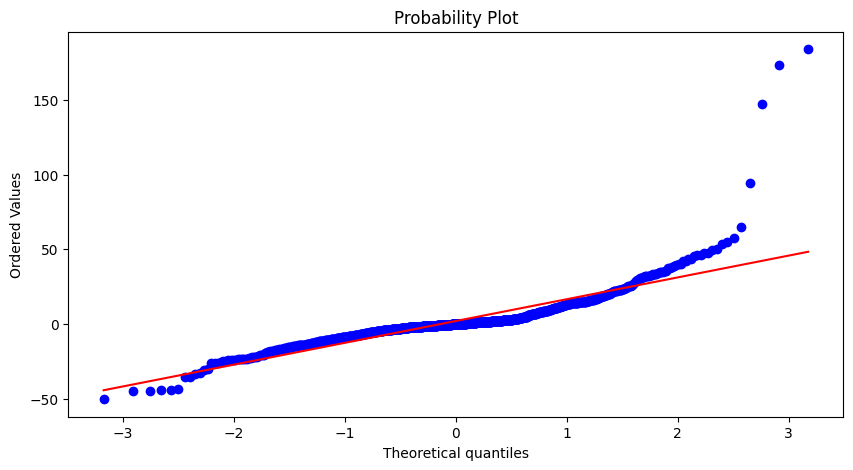

In [307]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR RIDGE 
#--------------------------------------------------
prob_plot(ridge_residuals)

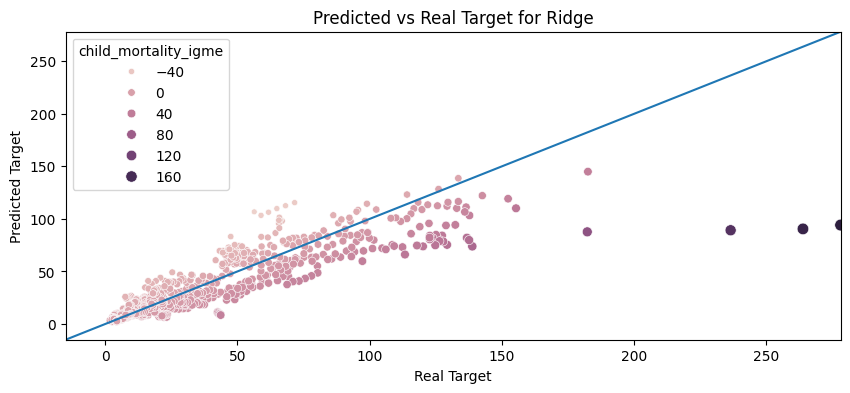

In [288]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR RIDGE
#--------------------------------------------------
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

In [289]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", ElasticNet(max_iter=5000,random_state=99))
])
#Target is rightskewed, logtransform y before training
elasticnet_pipeline_y_log = TransformedTargetRegressor(
    regressor=elasticnet_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

elasticnet_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1, 10],
    "regressor__model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline_y_log, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_cl_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [0.8, 0.78, 0.79, 0.81, 0.8]
            
Mean Train R2 Score: 0.8
            
Test Folds R2 Scores: [0.67, 0.79, 0.8, 0.73, 0.76]
            
Mean Test R2 Score (best_score_): 0.75

MAE:

Train Folds MAE Scores: [9.21, 8.58, 8.53, 8.46, 8.76]
            
Mean Train MAE Score: 8.71
            
Test Folds MAE Scores: [7.44, 10.52, 10.55, 10.49, 8.49]
            
Mean Test MAE Score: 9.5
            
Std Test MAE Score: 1.29

RMSE:

Train Folds RMSE Scores: [17.05, 16.16, 16.29, 13.74, 16.7]
            
Mean Train RMSE Score: 15.99
            
Test Folds RMSE Scores: [10.1, 18.55, 15.4, 24.58, 12.93]
            
Mean Test RMSE Score: 16.31
            
Std Test MAE Score: 4.98
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


In [290]:
best_elasticnet_model.regressor_.named_steps["model"].n_iter_

98

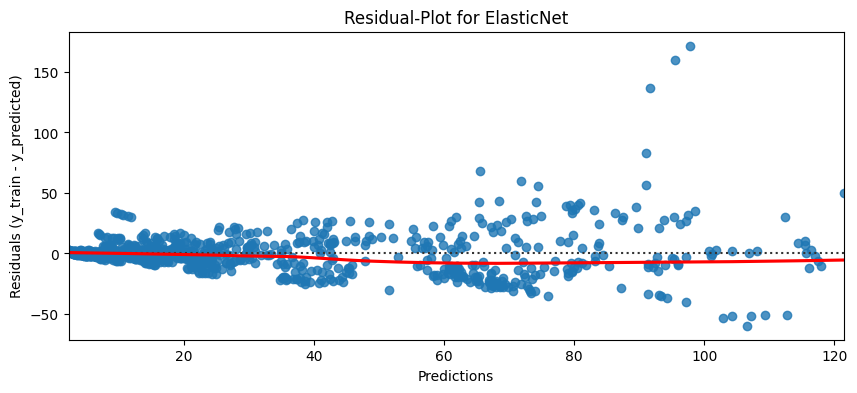

In [291]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_cl_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

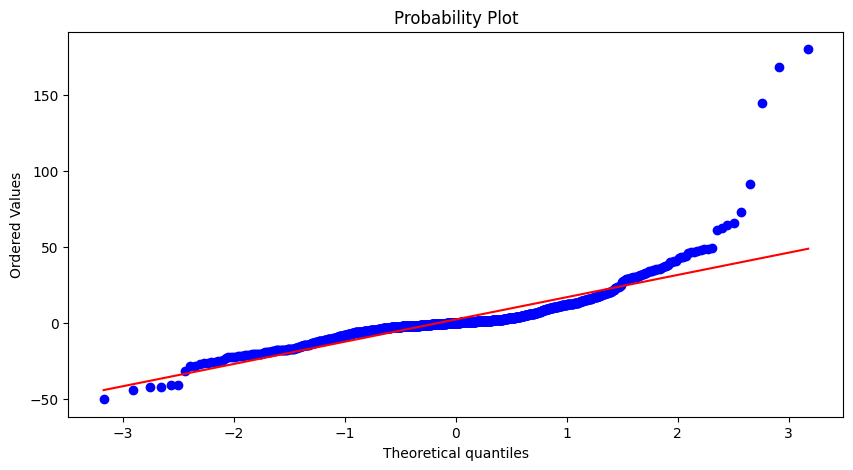

In [308]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

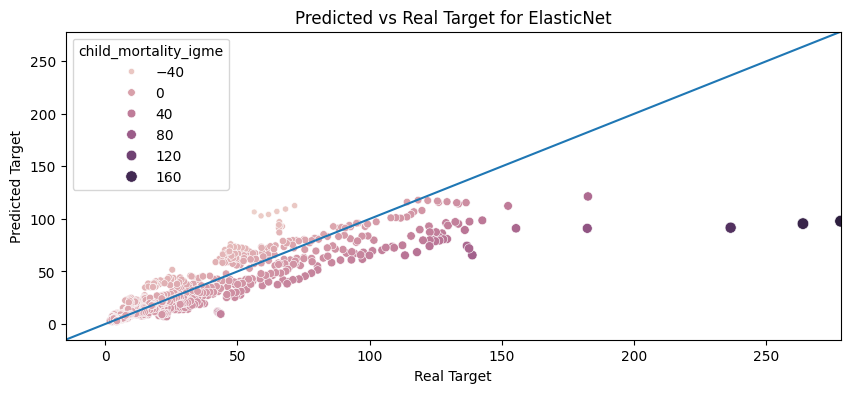

In [294]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

In [225]:
final_elastic_model = best_elasticnet_model.fit(X_cl_train, y_train)

In [231]:
X_test_elastic = X_test[num_variables].copy()

#cluster before on testset
X_test_scaled = kmeans_rscaler.transform(X_test_elastic)  
X_test_imputed = knn_impute.transform(X_test_scaled)  

km_dist_test = km_train.transform(X_test_imputed)
kmeans_cluster_columns_test = pd.DataFrame(km_dist_test,
                                           columns=km_distcols,
                                           index=X_test_elastic.index)


X_test_final = pd.concat([X_test.copy(), kmeans_cluster_columns_test], axis=1)
#X_test_final = X_test_final[X_cl_train.columns]


elasticnet_y_pred = final_elastic_model.predict(X_test_final)
MAE_test = mean_absolute_error(y_test, elasticnet_y_pred)
R2_test  = r2_score(y_test, elasticnet_y_pred)

print(MAE_test, R2_test)
print(np.abs(y_test - elasticnet_y_pred) / y_test * 100)

5.801869823225371 0.8466254537088957
60      16.532205
61      17.386864
62      12.449525
63       5.473497
64       8.939166
          ...    
1171    19.017796
1172    57.720302
1173    43.337564
1174    28.427395
1175    45.502595
Name: child_mortality_igme, Length: 234, dtype: float64


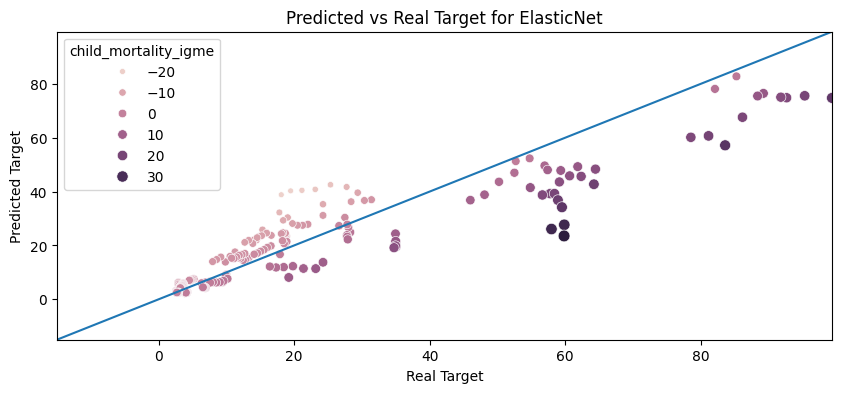

In [295]:
elasticnet_test_residuals = y_test - elasticnet_y_pred
actual_vs_predicted(y_test, elasticnet_y_pred, elasticnet_test_residuals, "ElasticNet")

### HuberRegressor

In [313]:
# -------------------------------------------------
# HuberRegressor
#--------------------------------------------------
huber_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", HuberRegressor(max_iter=5000))
])
#Target is rightskewed, logtransform y before training
huber_pipeline_y_log = TransformedTargetRegressor(
    regressor=huber_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

huber_param_grid = {
    "regressor__model__alpha": [0.01, 0.1, 1],
    "regressor__model__epsilon": [1.1, 1.35, 1.5, 1.75]
}

huber_grid = GridSearchCV(huber_pipeline_y_log, huber_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
huber_grid.fit(X_cl_train, y_train, groups=group_train)
best_huber_model = huber_grid.best_estimator_

show_scores(huber_grid, "HuberRegressor")

huber_grid.best_estimator_


------HuberRegressor CV SCORES--------

R2:

Train Folds R2 Scores: [0.8, 0.78, 0.8, 0.83, 0.8]
            
Mean Train R2 Score: 0.8
            
Test Folds R2 Scores: [0.67, 0.85, 0.79, 0.7, 0.73]
            
Mean Test R2 Score (best_score_): 0.75

MAE:

Train Folds MAE Scores: [8.92, 8.25, 7.96, 7.75, 8.23]
            
Mean Train MAE Score: 8.22
            
Test Folds MAE Scores: [7.55, 8.97, 10.72, 12.42, 9.15]
            
Mean Test MAE Score: 9.76
            
Std Test MAE Score: 1.67

RMSE:

Train Folds RMSE Scores: [17.33, 16.15, 16.0, 12.8, 16.6]
            
Mean Train RMSE Score: 15.78
            
Test Folds RMSE Scores: [10.06, 15.54, 15.76, 25.89, 13.8]
            
Mean Test RMSE Score: 16.21
            
Std Test MAE Score: 5.25
-----------------------------------------



,regressor,Pipeline(step..._iter=5000))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


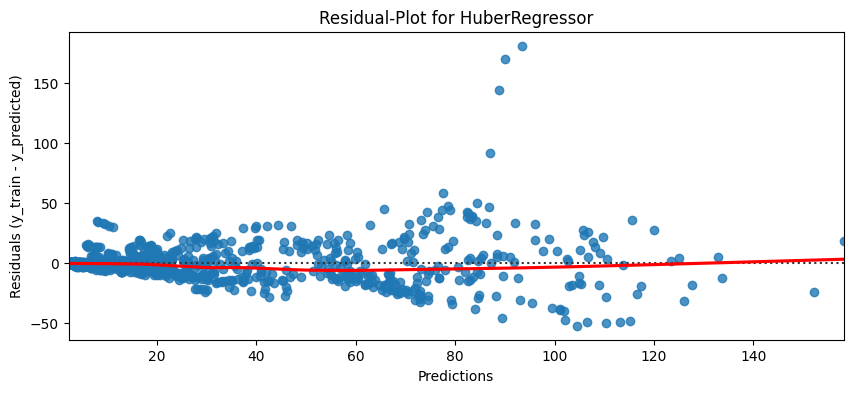

In [314]:
# -------------------------------------------------
# RESIDUAL PLOT FOR HuberRegressor
#--------------------------------------------------
huber_y_predicts = cross_val_predict(best_huber_model, X_cl_train, y_train, groups=group_train, cv=gk)
huber_residuals = y_train - huber_y_predicts

residual_plot(huber_y_predicts, huber_residuals, "HuberRegressor")

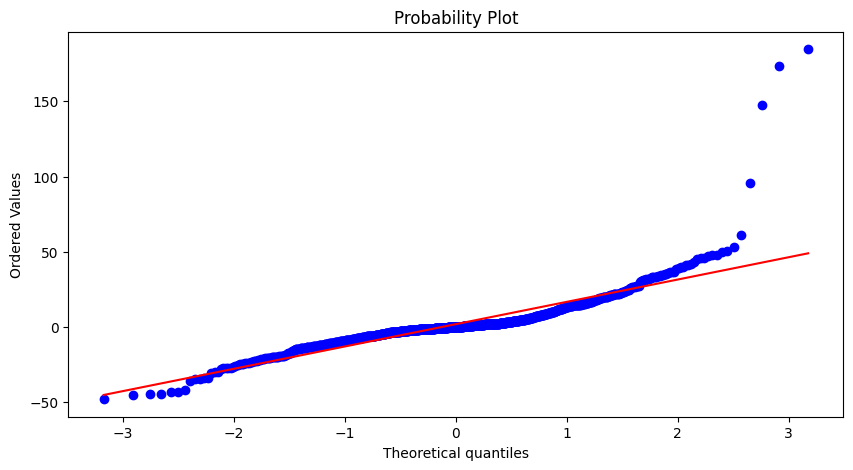

In [315]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR HUBER 
#--------------------------------------------------
prob_plot(huber_residuals)

### Random Forest Regressor

In [301]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
rf_pipeline_y_log = TransformedTargetRegressor(
    regressor=rf_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

rf_param_grid = {
    'regressor__model__n_estimators': [200, 500],
    'regressor__model__max_depth': [3, 5, 8],
    #'regressor__model__min_samples_split': [10, 20],
    'regressor__model__min_samples_leaf': [5, 10, 20],
    #'regressor__model__max_features': ['sqrt']
}

rf_grid = GridSearchCV(rf_pipeline_y_log, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_cl_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [0.95, 0.93, 0.95, 0.97, 0.95]
            
Mean Train R2 Score: 0.95
            
Test Folds R2 Scores: [0.7, 0.79, 0.63, 0.71, 0.77]
            
Mean Test R2 Score (best_score_): 0.72

MAE:

Train Folds MAE Scores: [3.48, 3.18, 3.33, 2.85, 3.14]
            
Mean Train MAE Score: 3.2
            
Test Folds MAE Scores: [7.04, 10.04, 12.42, 11.3, 8.44]
            
Mean Test MAE Score: 9.85
            
Std Test MAE Score: 1.93

RMSE:

Train Folds RMSE Scores: [8.64, 8.79, 8.29, 4.96, 8.18]
            
Mean Train RMSE Score: 7.77
            
Test Folds RMSE Scores: [9.63, 18.34, 21.21, 25.3, 12.83]
            
Mean Test RMSE Score: 17.46
            
Std Test MAE Score: 5.64
-----------------------------------------



,regressor,Pipeline(step...m_state=99))])
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


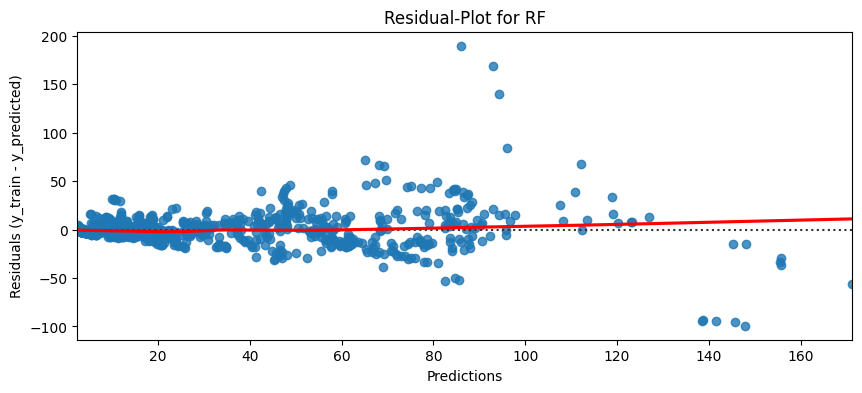

In [302]:
rf_y_predicts = cross_val_predict(best_rf_model, X_cl_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

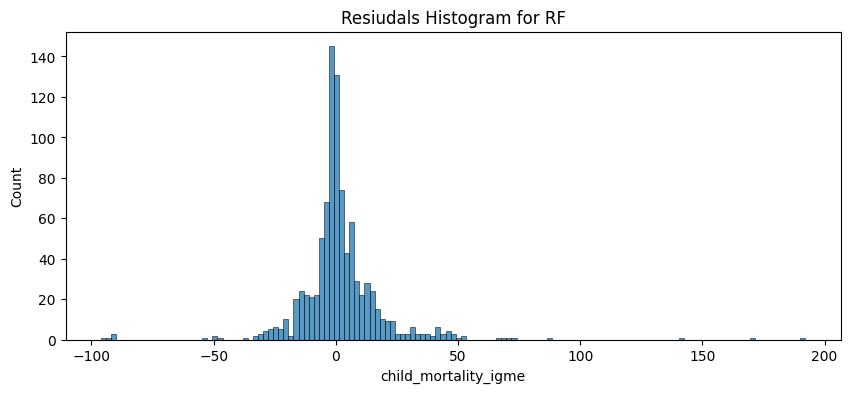

In [303]:
residuals_hist(rf_residuals, "RF")

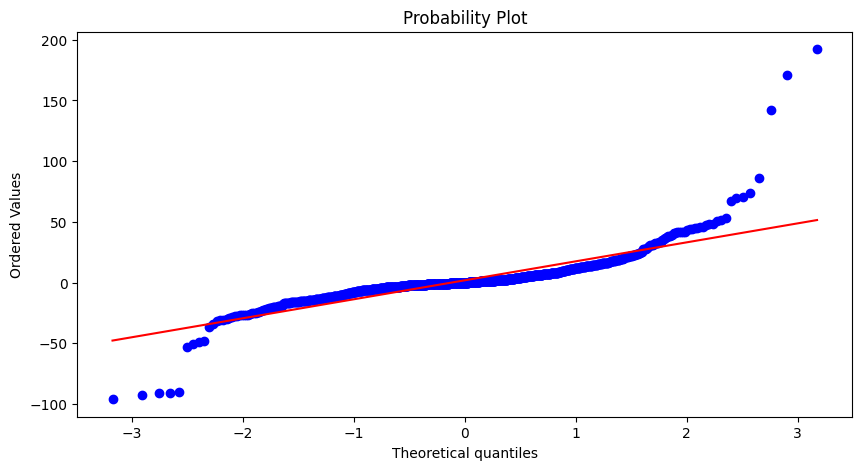

In [310]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR RF 
#--------------------------------------------------
prob_plot(rf_residuals)

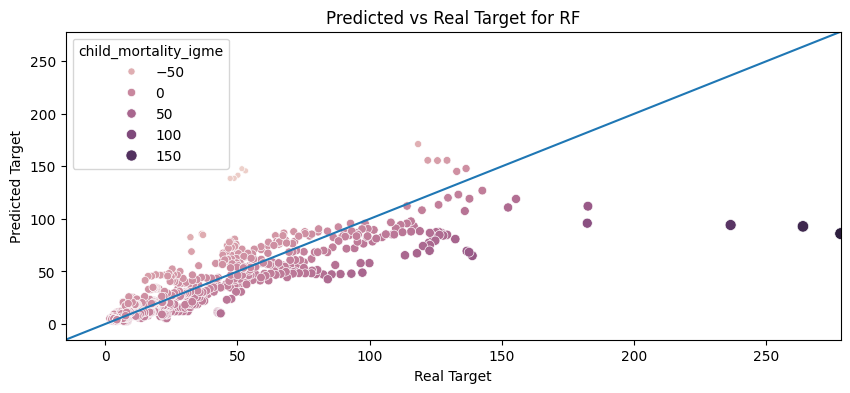

In [320]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

In [321]:
tolerance = 10  # absolute Toleranz, +/-2 Einheiten

correct = np.abs(rf_residuals) <= tolerance
n_correct = np.sum(correct)
percent_correct = n_correct / len(y_train) * 100

print(f"Correct within +,- {tolerance}: {n_correct} / {len(y_train)} ({percent_correct:.1f}%)")


Correct within +,- 10: 631 / 924 (68.3%)


In [322]:
correct = np.abs(ridge_residuals) <= tolerance
n_correct = np.sum(correct)
percent_correct = n_correct / len(y_train) * 100

print(f"Correct within +,- {tolerance}: {n_correct} / {len(y_train)} ({percent_correct:.1f}%)")


Correct within +,- 10: 621 / 924 (67.2%)


In [323]:
print("MAE test:", mean_absolute_error(y_train, rf_y_predicts))

MAE test: 9.859315012856461


In [324]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", XGBRegressor(objective="reg:pseudohubererror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
xgb_pipeline_y_log = TransformedTargetRegressor(
    regressor=xgb_pipeline,
    func=np.log1p,
    inverse_func=np.expm1
)

#xgb_param_grid = {
#    'regressor__model__n_estimators': [100, 300, 600],
#    'regressor__model__max_depth': [4, 6],
#    'regressor__model__learning_rate': [0.01, 0.05],
#    'regressor__model__subsample': [0.6, 0.8],
#    'regressor__model__colsample_bytree': [0.5, 0.8], 
#    'regressor__model__min_child_weight': [1, 5]
#}

from scipy.stats import randint, uniform, loguniform

xgb_param_grid = {
    #"regressor__model__n_estimators": [1000, 1500],
    "regressor__model__max_depth": [3, 4, 6],
    "regressor__model__learning_rate": [0.03, 0.1],
    #"regressor__model__subsample": [0.6, 0.7],          
    #"regressor__model__colsample_bytree": [0.5, 0.7],
    #"regressor__model__gamma": [1.0],  
    #"regressor__model__min_child_weight": [10],
    #"regressor__model__reg_alpha": [0.1, 0.3],
    #"regressor__model__reg_lambda": [1, 1.5],
}
#w = np.sqrt(np.log1p(y_train))
#w = np.clip(w, 0.5, 5.0)
#w = w / w.mean()
#xgb_search = RandomizedSearchCV(estimator=xgb_pipeline_y_log, param_distributions=xgb_param_grid, n_iter=40, cv=gk, scoring=metrics, refit="rmsle", n_jobs=-1, return_train_score=True, verbose=2, random_state=99, error_score="raise")
xgb_search = GridSearchCV(xgb_pipeline_y_log, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_cl_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [1.0, 1.0, 1.0, 1.0, 1.0]
            
Mean Train R2 Score: 1.0
            
Test Folds R2 Scores: [0.39, 0.8, 0.8, 0.72, 0.62]
            
Mean Test R2 Score (best_score_): 0.66

MAE:

Train Folds MAE Scores: [0.99, 0.73, 0.71, 0.59, 0.69]
            
Mean Train MAE Score: 0.74
            
Test Folds MAE Scores: [9.54, 9.87, 10.94, 11.36, 10.74]
            
Mean Test MAE Score: 10.49
            
Std Test MAE Score: 0.68

RMSE:

Train Folds RMSE Scores: [1.99, 1.59, 1.47, 1.02, 1.38]
            
Mean Train RMSE Score: 1.49
            
Test Folds RMSE Scores: [13.66, 17.72, 15.67, 25.18, 16.46]
            
Mean Test RMSE Score: 17.74
            
Std Test MAE Score: 3.95
-----------------------------------------



,regressor,"Pipeline(step...=None, ...))])"
,transformer,None
,func,<ufunc 'log1p'>
,inverse_func,<ufunc 'expm1'>
,check_inverse,True
,transformers,"[('numeric_1', ...), ('numeric_2', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


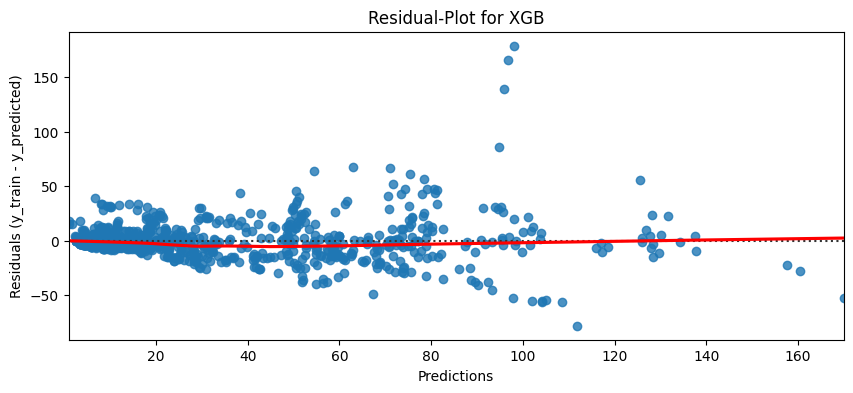

In [325]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_cl_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

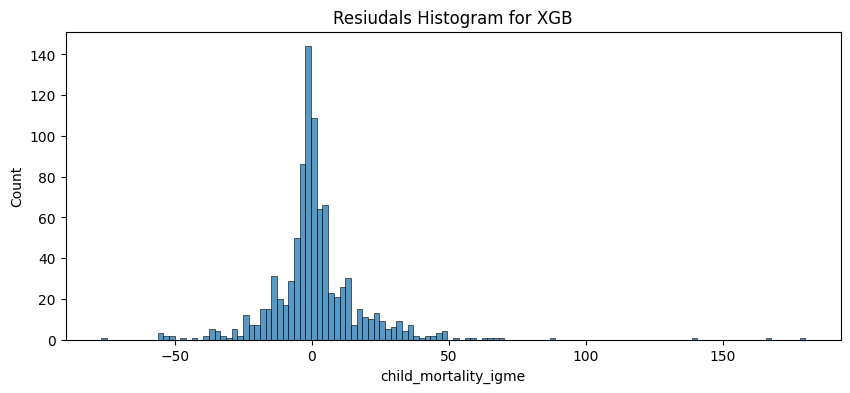

In [326]:
residuals_hist(xgb_residuals, "XGB")

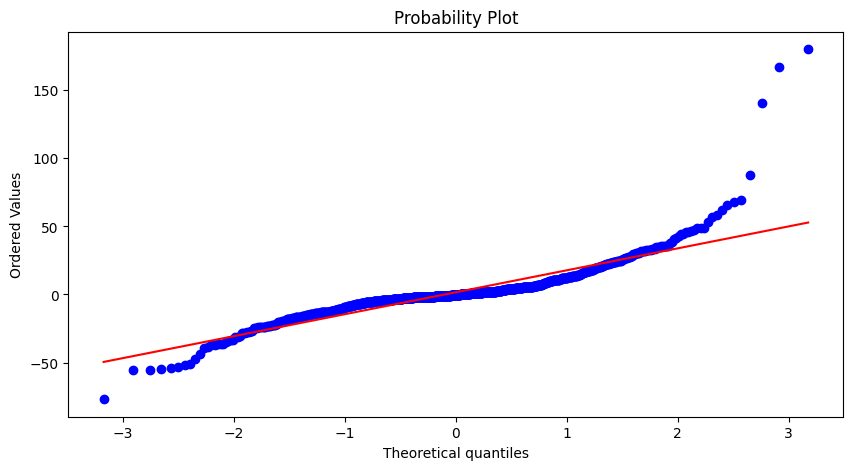

In [327]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR XGB
#--------------------------------------------------
prob_plot(xgb_residuals)

In [91]:
#actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")